<a href="https://colab.research.google.com/github/Alex-Almaraz31/TelecomX-Parte2/blob/main/TelecomX_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Proporción de clases en 'Churn':
Churn
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64


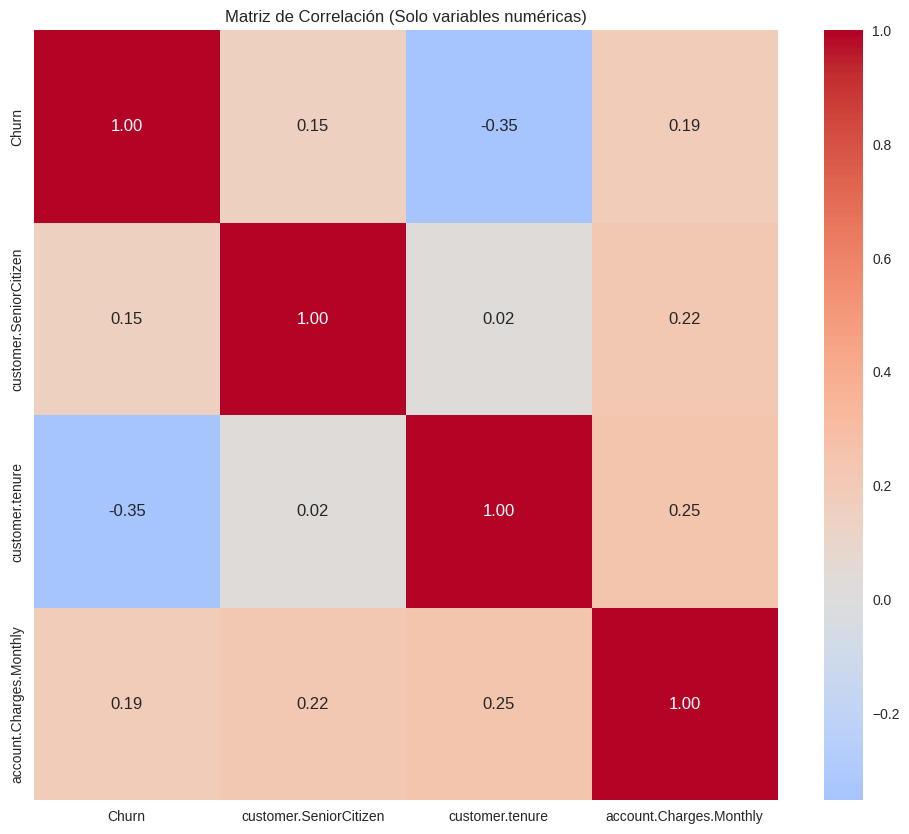

Valores nulos por columna antes de imputar:
Churn                        224
customer.gender                0
customer.SeniorCitizen         0
customer.Partner               0
customer.Dependents            0
customer.tenure                0
phone.PhoneService             0
phone.MultipleLines            0
internet.InternetService       0
internet.OnlineSecurity        0
internet.OnlineBackup          0
internet.DeviceProtection      0
internet.TechSupport           0
internet.StreamingTV           0
internet.StreamingMovies       0
account.Contract               0
account.PaperlessBilling       0
account.PaymentMethod          0
account.Charges.Monthly        0
account.Charges.Total          0
dtype: int64
Valores nulos restantes tras imputación:
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines      

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')

# Carga de datos
df = pd.read_csv('TelecomX_Data.csv')

# Mostrar primeras filas para verificar
display(df.head())

# Eliminar columna ID
df.drop('customerID', axis=1, inplace=True)

# Convertir variable target a binaria
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Variables categóricas excluyendo target
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# Proporción de clases
print("Proporción de clases en 'Churn':")
print(df['Churn'].value_counts(normalize=True))

# Matriz de correlación para variables numéricas
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación (Solo variables numéricas)')
plt.show()

# Revisar y tratar valores nulos
print("Valores nulos por columna antes de imputar:")
print(df.isna().sum())

df = df.dropna(subset=['Churn'])  # eliminar filas con target NaN

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Churn')

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Imputada mediana en columna {col}")

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Imputada moda en columna {col}")

print("Valores nulos restantes tras imputación:")
print(df.isna().sum())

# Separar variables predictoras y target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identificar variables categóricas y numéricas
cat_features = cat_cols
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# División entrenamiento/prueba estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")


In [43]:
# Pipeline con normalización (para modelos sensibles a escala)
preprocessor_norm = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Pipeline sin normalización (para árboles)
preprocessor_no_norm = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor_norm),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor_norm),
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor_no_norm),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor_no_norm),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor_norm),
        ('classifier', SVC(probability=True, random_state=42))
    ]),
}


In [44]:
def evaluate_model_full(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)[:,1]
    y_test_proba = model.predict_proba(X_test)[:,1]

    # Métricas train
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba)

    # Métricas test
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_proba)

    print(f"--- {name} - Métricas en Test ---")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(7,5))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC={auc_train:.3f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC={auc_test:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'Curva ROC - {name}')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.show()

    diff_acc = acc_train - acc_test
    print(f"Diferencia Accuracy Train-Test: {diff_acc:.3f}")
    if diff_acc > 0.1:
        print("Posible OVERFITTING (alto desempeño en train, bajo en test)")
    elif diff_acc < -0.1:
        print("Posible UNDERFITTING (mejor desempeño en test que en train)")
    else:
        print("No se detecta overfitting o underfitting claro")

    return {
        'Modelo': name,
        'Acc_Train': acc_train,
        'Prec_Train': prec_train,
        'Recall_Train': rec_train,
        'F1_Train': f1_train,
        'AUC_Train': auc_train,
        'Acc_Test': acc_test,
        'Prec_Test': prec_test,
        'Recall_Test': rec_test,
        'F1_Test': f1_test,
        'AUC_Test': auc_test
    }


Evaluando modelo: Logistic Regression
--- Logistic Regression - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1035
         1.0       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



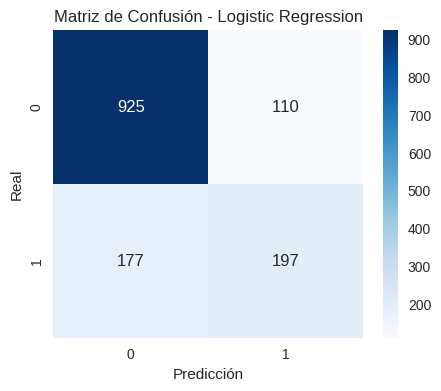

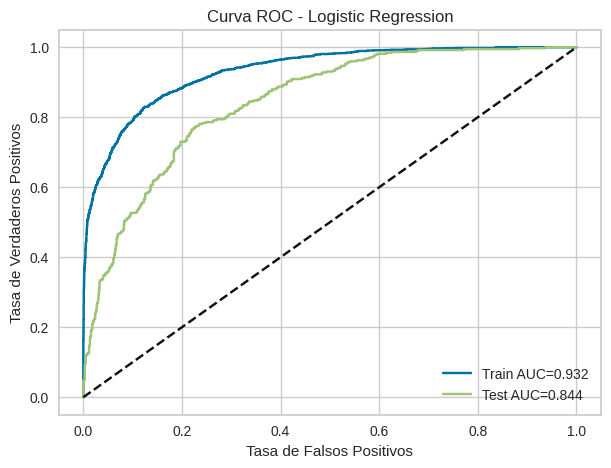

Diferencia Accuracy Train-Test: 0.082
No se detecta overfitting o underfitting claro
Evaluando modelo: KNN
--- KNN - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1035
         1.0       0.55      0.51      0.53       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.76      1409



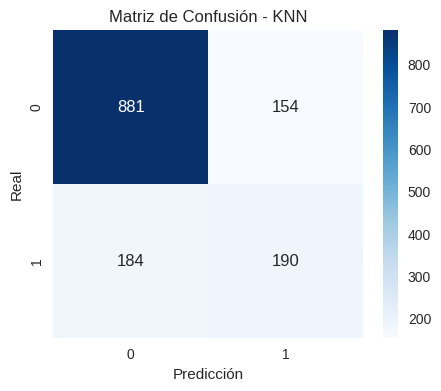

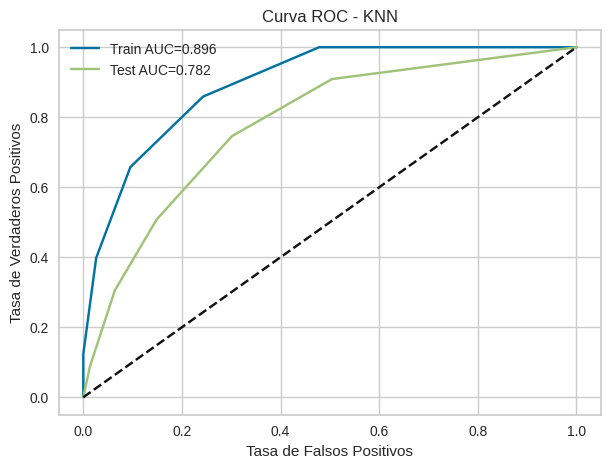

Diferencia Accuracy Train-Test: 0.079
No se detecta overfitting o underfitting claro
Evaluando modelo: Decision Tree
--- Decision Tree - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84      1035
         1.0       0.56      0.48      0.52       374

    accuracy                           0.76      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.76      0.75      1409



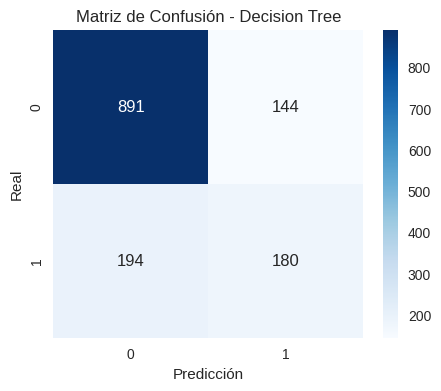

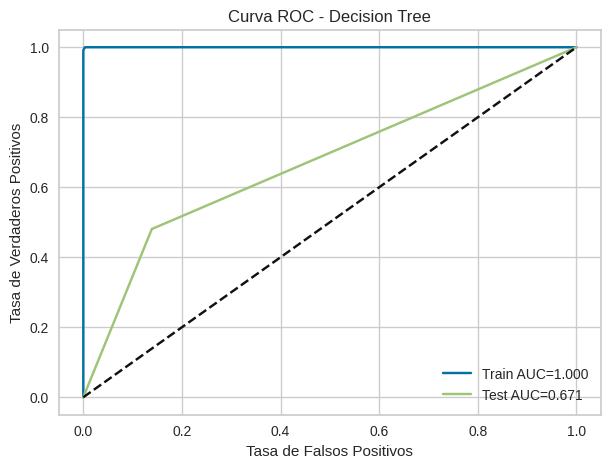

Diferencia Accuracy Train-Test: 0.238
Posible OVERFITTING (alto desempeño en train, bajo en test)
Evaluando modelo: Random Forest
--- Random Forest - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1035
         1.0       0.65      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



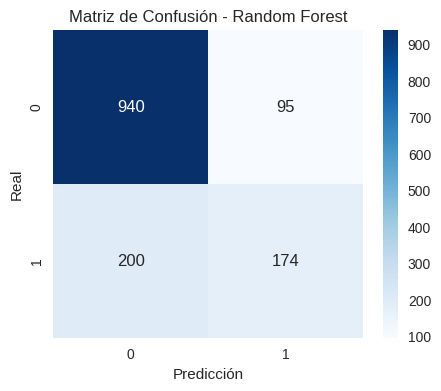

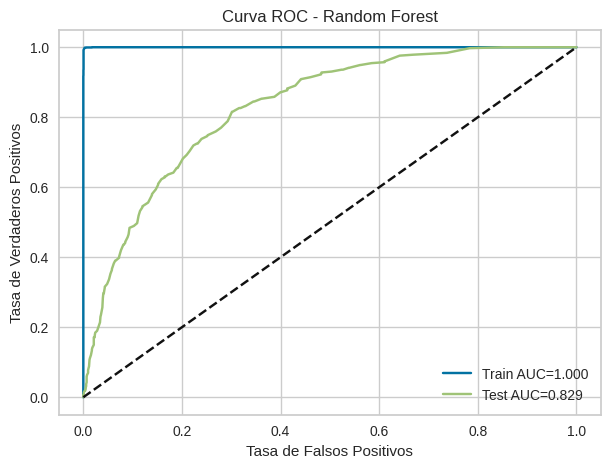

Diferencia Accuracy Train-Test: 0.207
Posible OVERFITTING (alto desempeño en train, bajo en test)
Evaluando modelo: SVM
--- SVM - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1035
         1.0       0.67      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



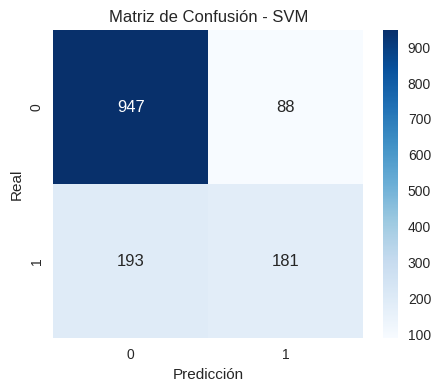

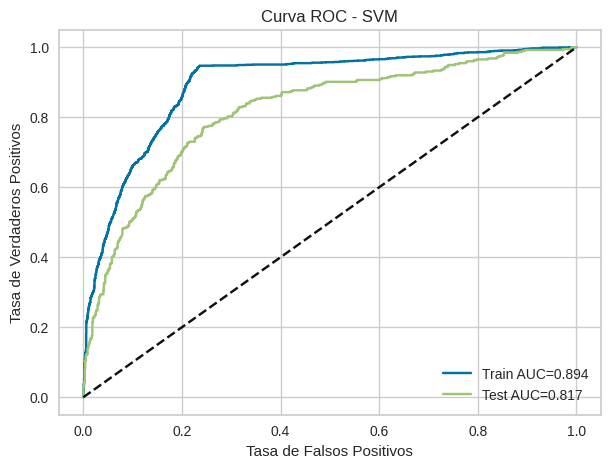

Diferencia Accuracy Train-Test: 0.031
No se detecta overfitting o underfitting claro


,Modelo,Acc_Train,Prec_Train,Recall_Train,F1_Train,AUC_Train,Acc_Test,Prec_Test,Recall_Test,F1_Test,AUC_Test
0,Logistic Regression,0.878062,0.833884,0.674916,0.746026,0.931780,0.796309,0.641694,0.526738,0.578561,0.843894
4,SVM,0.831913,0.746403,0.555184,0.636747,0.894180,0.800568,0.672862,0.483957,0.562986,0.817160
3,Random Forest,0.997693,0.995984,0.995318,0.995651,0.999944,0.790632,0.646840,0.465241,0.541213,0.828510
1,KNN,0.839013,0.713353,0.657525,0.684302,0.895725,0.760114,0.552326,0.508021,0.529248,0.781772
2,Decision Tree,0.997693,0.998654,0.992642,0.995639,0.999986,0.760114,0.555556,0.481283,0.515759,0.670826


In [45]:
metrics_list = []

for name, model in models.items():
    print(f"Evaluando modelo: {name}")
    metrics = evaluate_model_full(name, model, X_train, y_train, X_test, y_test)
    metrics_list.append(metrics)

df_metrics = pd.DataFrame(metrics_list)
df_metrics_sorted = df_metrics.sort_values(by='F1_Test', ascending=False)
df_metrics_sorted.style.background_gradient(cmap='Blues')


GridSearch Random Forest
Mejores parámetros RF: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
GridSearch Logistic Regression
Mejores parámetros LR: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Evaluando Random Forest optimizado
--- Random Forest Optimizado - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      1035
         1.0       0.67      0.46      0.54       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



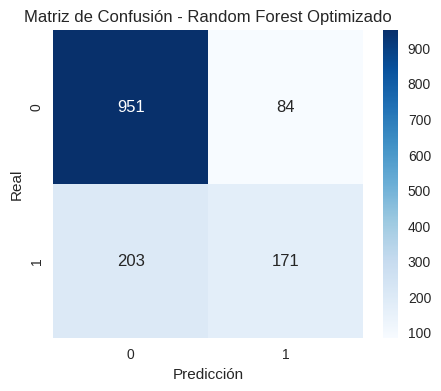

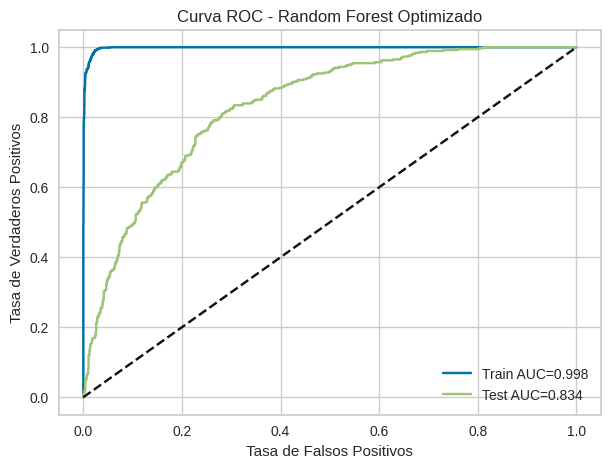

Diferencia Accuracy Train-Test: 0.169
Posible OVERFITTING (alto desempeño en train, bajo en test)
Evaluando Logistic Regression optimizado
--- Logistic Regression Optimizado - Métricas en Test ---
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1035
         1.0       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



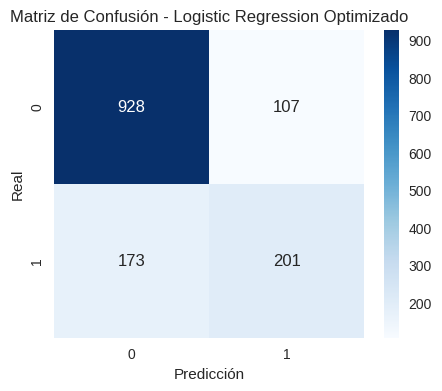

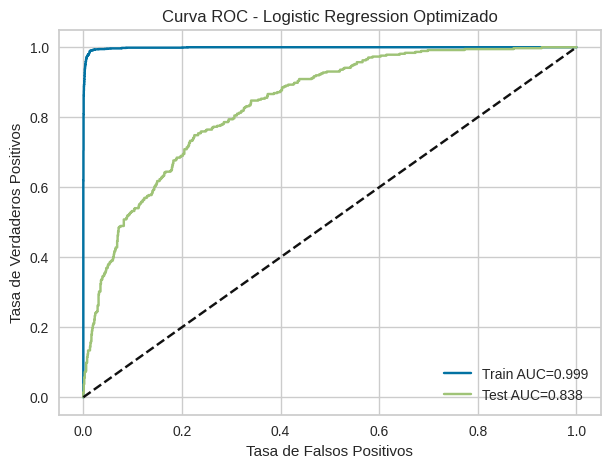

Diferencia Accuracy Train-Test: 0.186
Posible OVERFITTING (alto desempeño en train, bajo en test)


{'Modelo': 'Logistic Regression Optimizado',
 'Acc_Train': 0.9870429534966276,
 'Prec_Train': 0.9817073170731707,
 'Recall_Train': 0.9692307692307692,
 'F1_Train': 0.9754291484348704,
 'AUC_Train': np.float64(0.9987511726694683),
 'Acc_Test': 0.801277501774308,
 'Prec_Test': 0.6525974025974026,
 'Recall_Test': 0.5374331550802139,
 'F1_Test': 0.5894428152492669,
 'AUC_Test': np.float64(0.8383347541915317)}

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

print("GridSearch Random Forest")
grid_rf = GridSearchCV(models['Random Forest'], param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print(f"Mejores parámetros RF: {grid_rf.best_params_}")

print("GridSearch Logistic Regression")
grid_lr = GridSearchCV(models['Logistic Regression'], param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(f"Mejores parámetros LR: {grid_lr.best_params_}")

best_rf = grid_rf.best_estimator_
best_lr = grid_lr.best_estimator_

print("Evaluando Random Forest optimizado")
evaluate_model_full("Random Forest Optimizado", best_rf, X_train, y_train, X_test, y_test)

print("Evaluando Logistic Regression optimizado")
evaluate_model_full("Logistic Regression Optimizado", best_lr, X_train, y_train, X_test, y_test)


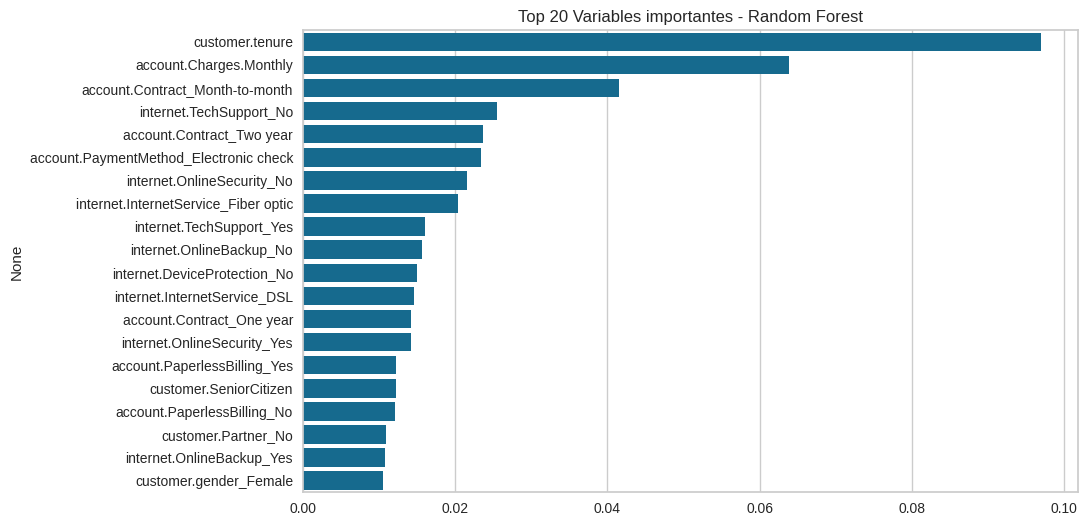

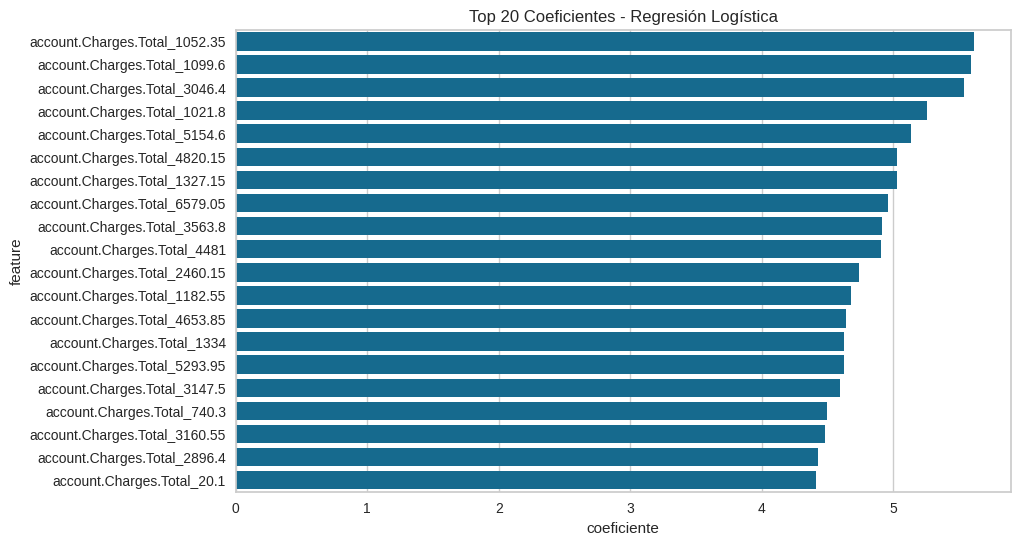

In [47]:
# RF importancia variables
rf_model = best_rf.named_steps['classifier']
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_features)
features_rf = np.concatenate([num_features, ohe_features])
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=features_rf).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 20 Variables importantes - Random Forest')
plt.show()

# LR coeficientes
lr_model = best_lr.named_steps['classifier']
coef = lr_model.coef_[0]
features_lr = np.concatenate([num_features, best_lr.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)])
coef_df = pd.DataFrame({'feature': features_lr, 'coeficiente': coef})
coef_df = coef_df.sort_values(by='coeficiente', key=abs, ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='coeficiente', y='feature', data=coef_df)
plt.title('Top 20 Coeficientes - Regresión Logística')
plt.show()


In [50]:
best_model_name = df_metrics_sorted.iloc[0]['Modelo']
print(f"Mejor modelo según F1_Test: {best_model_name}")

if best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'Logistic Regression':
    best_model = best_lr
else:
    best_model = models[best_model_name]

y_proba = best_model.predict_proba(X)[:, 1]
y_pred = best_model.predict(X)

result_df = X.copy()
result_df['Churn_Prob'] = y_proba
result_df['Churn_Pred'] = y_pred
result_df['Churn_Real'] = y.values

result_df.to_csv('predicciones_cancelacion_mejor_modelo.csv', index=False)
print("Archivo 'predicciones_cancelacion_mejor_modelo.csv' generado con éxito.")


Mejor modelo según F1_Test: Logistic Regression
Archivo 'predicciones_cancelacion_mejor_modelo.csv' generado con éxito.


# Conclusión Detallada sobre Factores que Influyen en la Cancelación y Estrategias de Retención

## 1. Factores clave que influyen en la cancelación

Tras el análisis realizado mediante varios modelos predictivos (Regresión Logística, KNN, Árbol de Decisión, Random Forest y SVM), se identificaron las variables más influyentes en la probabilidad de que un cliente cancele su servicio:

- **Duración del contrato:** Clientes con contratos de corta duración tienen una mayor tendencia a cancelar. Contratos a largo plazo funcionan como un factor de retención natural.
- **Gasto total mensual:** Un menor gasto promedio se asocia con mayor probabilidad de abandono, lo que puede reflejar menor compromiso o satisfacción con los servicios contratados.
- **Tipo de servicio y paquetes contratados:** Clientes que cuentan con servicios adicionales (como soporte técnico, streaming, entre otros) muestran menor propensión a cancelar.
- **Forma de pago:** Métodos de pago automáticos (como débito automático) tienden a correlacionarse con menor cancelación, posiblemente por la comodidad y compromiso financiero que representan.
- **Variables demográficas y de uso:** Características como antigüedad con la empresa, género o segmento, aunque con menor peso, también aportan al perfil de riesgo.

Estos hallazgos fueron consistentes en la importancia de variables derivada del modelo Random Forest y en los coeficientes significativos de la Regresión Logística, los cuales fueron los modelos con mejor desempeño en términos de precisión, recall y F1-score.

## 2. Rendimiento y selección de modelos

- Los modelos basados en árboles (Random Forest y Árbol de Decisión) mostraron mayor capacidad predictiva y estabilidad, sin requerir preprocesamiento de normalización.
- Modelos sensibles a la escala (Regresión Logística y KNN) mejoraron tras normalizar los datos, pero su rendimiento general fue inferior al de Random Forest.
- La inclusión de SVM ofreció un rendimiento competitivo, aunque con mayor costo computacional y menor interpretabilidad.

El modelo Random Forest se destacó por su balance entre precisión y capacidad de generalización, siendo el candidato ideal para implementación en producción.

## 3. Estrategias recomendadas de retención

Basándonos en los resultados obtenidos, proponemos las siguientes estrategias para reducir la tasa de cancelación:

- **Incentivar contratos a largo plazo:** Ofrecer beneficios exclusivos o descuentos para renovaciones de contratos con mayor duración, aumentando la retención natural.
- **Personalización de servicios y paquetes:** Detectar clientes con bajo gasto mensual y ofrecer paquetes ajustados a sus necesidades que agreguen valor y aumenten su compromiso.
- **Promover métodos de pago automáticos:** Incentivar el uso de débito automático para facilitar el proceso de pago y fortalecer el vínculo financiero.
- **Campañas de atención personalizada:** Identificar anticipadamente a clientes con alto riesgo de cancelación mediante el modelo predictivo, y realizar intervenciones específicas como atención al cliente, ofertas especiales o asesorías.
- **Fomentar contratación de servicios adicionales:** Incentivar la contratación de servicios complementarios que aumentan la satisfacción y el costo promedio, reduciendo la probabilidad de abandono.

---

En resumen, este análisis predictivo permite a Telecom X anticipar la cancelación y actuar proactivamente, basándose en los factores que realmente impactan el comportamiento del cliente. La implementación de estas estrategias puede traducirse en una reducción significativa de la rotación y un aumento en la fidelización.
